# Java CLgen Model

In [10]:
## Imports

import collections
import pathlib
import random
import shutil
import typing
import math

import matplotlib
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sqlalchemy as sql

from matplotlib import pyplot as plt

from labm8 import app
from labm8 import prof
from labm8 import sqlutil
from labm8 import labdate
from labm8 import pbutil
from labm8 import viz
from labm8 import labtypes
from labm8 import humanize

from deeplearning.clgen import clgen
from deeplearning.clgen import samples_database
from deeplearning.clgen import samplers
from deeplearning.clgen import sample_observers
from deeplearning.clgen.proto import model_pb2
from deeplearning.clgen.proto import sampler_pb2
from datasets.github.scrape_repos import contentfiles
from deeplearning.clgen.corpuses import preprocessed
from deeplearning.clgen.corpuses import encoded
from experimental.deeplearning.deepsmith.java_fuzz import sample_java_model

FLAGS = app.FLAGS(['argv0'])
%matplotlib inline

In [11]:
# Variables.

db_url = sqlutil.ResolveUrl('file:///var/phd/db/cc1.mysql')

enc_db = f'{db_url}github_java_methods_enc_2019.07.02?charset=utf8'
samples_db = f'{db_url}java_model_samples_2019.07.22?charset=utf8'
clgen_working_dir = '/var/phd/experimental/deeplearning/deepsmith/java_fuzz/clgen_cache'

enc_db = encoded.EncodedContentFiles(enc_db, must_exist=True)
samples_db = samples_database.SamplesDatabase(samples_db, must_exist=True)
working_dir = pathlib.Path(clgen_working_dir)

In [12]:
with enc_db.Session() as s, prof.ProfileToStdout('query'):
    enc_methods_count = s.query(encoded.EncodedContentFile).count()

print(f'{humanize.Commas(enc_methods_count)} encoded methods in training corpus')

query in 929ms
460,072 encoded methods in training corpus


In [13]:
instance = sample_java_model.MakeClgenInstance(
    working_dir=working_dir,
    encoded_db=enc_db,
    num_training_epochs=50,
    seed_text='public ',
    neurons_per_layer=1024,
)
with instance.Session() as session:
    print(session.model)
    print(f'Is model trained? {session.model.is_trained}')
    telemetry = session.model.TrainingTelemetry()

model[8d608cd56ed1e45386fc3a819f703473648442d8]
Is model trained? True


## Model Training Stats

In [14]:
training_time = sum([t.epoch_wall_time_ms for t in telemetry])
df = pd.DataFrame([
    ('Total training time', humanize.Duration(training_time / 1e3)),
    ('Time per epoch', humanize.Duration(training_time / len(telemetry) / 1e3)),
    ('Diff between init and final loss', telemetry[0].loss - telemetry[-1].loss),
    ('Max loss at epoch', telemetry[[t.loss for t in telemetry].index(max(t.loss for t in telemetry))].epoch_num),
    ('Max loss', max(t.loss for t in telemetry)),
    ('Min loss at epoch', telemetry[[t.loss for t in telemetry].index(min(t.loss for t in telemetry))].epoch_num), 
    ('Min loss', min(t.loss for t in telemetry)),
], columns=['', ''])
df

,,
0,Total training time,4d 8h 34m 19s 805ms
1,Time per epoch,2h 5m 29s 196ms
2,Diff between init and final loss,-0.021118
3,Max loss at epoch,28
4,Max loss,110.503
5,Min loss at epoch,7
6,Min loss,0.43866


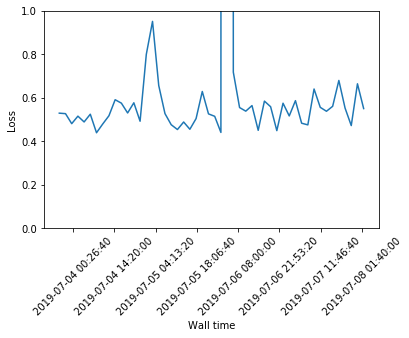

In [121]:
# Plot training loss over time.
plt.plot([t.timestamp_utc_epoch_ms for t in telemetry],
         [t.loss for t in telemetry])
plt.ylabel('Loss')
plt.xlabel('Wall time')
plt.ylim((0, 1))
viz.FormatXLabelsAsTimestamps('%Y-%m-%d %H:%M:%S')
viz.RotateXLabels(45)

### Investigating Training data

In [ ]:
# Get the atomizer

with instance.Session() as s:
    s.model.corpus.Create()
    atomizer = s.model.corpus.atomizer
atomizer

In [86]:
# Print a random method.

def Decode(encoded_method, atomizer):
    return atomizer.DeatomizeIndices(encoded_method.indices_array)

with enc_db.Session() as s:
    e = s.query(encoded.EncodedContentFile).order_by(enc_db.Random()).first()# .order_by(enc_db.Random).one()
    print(Decode(e, atomizer))

public static int fn_B(String a,String b){
  String[] c=a.split("\\.");
  String[] d=b.split("\\.");
  int e=0;
  while (e < c.length && e < d.length && c[e].equals(d[e])) {
    e++;
  }
  if (e < c.length && e < d.length) {
    int f=Integer.valueOf(c[e]).compareTo(Integer.valueOf(d[e]));
    return Integer.signum(f);
  }
  return Integer.signum(c.length - d.length);
}



### Make a sample with this model

In [124]:
seed = 'public static int fn_A(int a, int b){\n\t'

def SampleOneBatch(instance):
    sampler_config = sampler_pb2.Sampler()
    sampler_config.CopyFrom(instance.sampler.config)
    sampler_config.start_text = seed
    sampler = samplers.Sampler(sampler_config)
    
    observer = sample_observers.InMemorySampleSaver()
    with instance.Session() as s:
        instance.Sample([
            sample_observers.MaxSampleCountObserver(1),
            observer
        ])
    return observer.samples

samples = SampleOneBatch(instance)
print(samples[0].text)

public BigInteger b=new BigInteger(1589);
}


### Cached Samples